In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from src.data.utils import load_metadata

In [18]:
dataset_name = 'rossmann-store-sales'
metadata = load_metadata(dataset_name)

In [53]:
def visualize_conditional_embeddings(metadata):
    embeddings = dict()
    for table in metadata.get_tables():
        embeddings[table] = np.load(f'../ckpt/{table}/cond_train_z.npy')

    fig, axes = plt.subplots(1, len(embeddings), figsize=(len(embeddings) * 5, 5))
    cmap = plt.get_cmap('Set1')
    for i, (table, embedding) in enumerate(embeddings.items()):
        pca = PCA(n_components=2)
        pca.fit(embedding)
        embedding = pca.transform(embedding)
        axes[i].scatter(embedding[:, 0], embedding[:, 1], s=10, color=cmap(i))
        axes[i].set_title(table)
        axes[i].axis('equal')

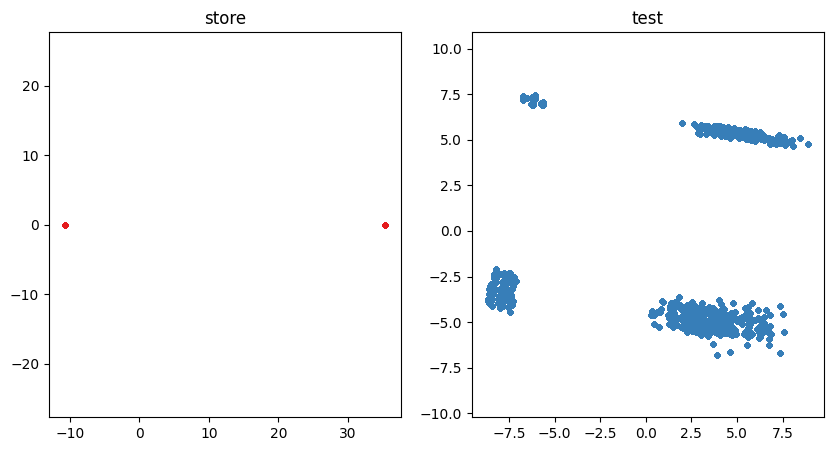

In [54]:
visualize_conditional_embeddings(metadata)